# STUDY DIFFERENT CH PREDICTORS

In [1]:
import click
import gzip
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2

import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

## 0. Import data

In [2]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

In [3]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
# boostDM_predictions['patient'] = boostDM_predictions['patient'].astype(str)
len(boostDM_predictions)

203351

In [4]:
### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.columns

/tmp/jobs/jramis/9874679/ipykernel_17330/1174477373.py:3: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       '22009-0.1', '22009-0.2', '22009-0.3', '22009-0.4', '22009-0.5',
       '22009-0.6', '22009-0.7', '22009-0.8', '22009-0.9', '22009-0.10'],
      dtype='object', length=139)

In [5]:
# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
ukb200K_ch_cancer.columns

Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_nonDriver',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       'var_Cervical_post', 'var_Cervical_pre', 'var_Sarcoma_years',
       'var_Sarcoma_var', 'var_Sarcoma_post', 'var_Sarcoma_pre',
       'var_Testicular_years', 'var_Testicular_var', 'var_Testicular_post',
       'var_Testicular_pre'],
      dtype='object', length=263)

In [6]:
# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

In [7]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })


In [8]:
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions_nonHN = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)]
len(boostDM_predictions_nonHN)

201857

In [9]:
boostDM_predictions_nonHN = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['SYMBOL'].isin(['MDM4', 'CHEK2'])]
len(boostDM_predictions_nonHN)

184379

In [10]:
### Annotate with boostDM-CH prediction
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t', compression='gzip')
Rules_matrix['ID2'] = Rules_matrix['chr'].astype(str) +"-"+\
                            Rules_matrix['pos'].astype(str) +"-"+\
                            Rules_matrix['alt'].astype(str)
Rules_matrix

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,ID2
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-C
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-G
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0,20-32358779-T
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-C
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-C
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-T
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-A
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-G


In [11]:
#Select mutations based on driver call
BoostDM_dirvers = Rules_matrix[Rules_matrix['boostDM_class']==1]
Niroula_dirvers = Rules_matrix[Rules_matrix['Niroula']==1]
Bick_dirvers = Rules_matrix[Rules_matrix['Bick']==1]
WHO_dirvers = Rules_matrix[Rules_matrix['WHO']==1]

In [12]:
boostDM_predictions_nonHN['BoostDM'] = np.where(boostDM_predictions_nonHN['ID2'].isin(BoostDM_dirvers['ID2'].to_list()), 1, 0)
print('BoostDM_Done')
boostDM_predictions_nonHN['Niroula'] = np.where(boostDM_predictions_nonHN['ID2'].isin(Niroula_dirvers['ID2'].to_list()), 1, 0)
print('Niroula_Done')
boostDM_predictions_nonHN['Bick'] = np.where(boostDM_predictions_nonHN['ID2'].isin(Bick_dirvers['ID2'].to_list()), 1, 0)
print('Bick_Done')
boostDM_predictions_nonHN['WHO'] = np.where(boostDM_predictions_nonHN['ID2'].isin(WHO_dirvers['ID2'].to_list()), 1, 0)
print('WHO_Done')

len(boostDM_predictions_nonHN)

BoostDM_Done
Niroula_Done
Bick_Done
WHO_Done


184379

## 1. Annotate Rules to perform analyses

In [13]:
# Remove cases with prior hematological cancer
ukb200K_ch_cancer_nonHN = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer_nonHN)

467202

In [14]:
patients_CHdrivers_Bick = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Bick'] == 1]['patient'].to_list()
print(len(patients_CHdrivers_Bick))
ukb200K_ch_cancer_nonHN['Bick_driver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_CHdrivers_Bick), 1, 0)
ukb200K_ch_cancer_nonHN['Bick_driver'].value_counts()

patients_nonCHdrivers_Bick = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Bick'] == 0]['patient'].to_list()
print(len(patients_nonCHdrivers_Bick))
ukb200K_ch_cancer_nonHN['Bick_nonDriver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_nonCHdrivers_Bick), 1, 0)
ukb200K_ch_cancer_nonHN['Bick_nonDriver'].value_counts()

patients_CHdrivers_Niroula = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Niroula'] == 1]['patient'].to_list()
print(len(patients_CHdrivers_Niroula))
ukb200K_ch_cancer_nonHN['Niroula_driver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_CHdrivers_Niroula), 1, 0)
ukb200K_ch_cancer_nonHN['Niroula_driver'].value_counts()

patients_nonCHdrivers_Niroula = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Niroula'] == 0]['patient'].to_list()
print(len(patients_nonCHdrivers_Niroula))
ukb200K_ch_cancer_nonHN['Niroula_nonDriver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_nonCHdrivers_Niroula), 1, 0)
ukb200K_ch_cancer_nonHN['Niroula_nonDriver'].value_counts()

patients_CHdrivers_WHO = boostDM_predictions_nonHN[boostDM_predictions_nonHN['WHO'] == 1]['patient'].to_list()
print(len(patients_CHdrivers_WHO))
ukb200K_ch_cancer_nonHN['WHO_driver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_CHdrivers_WHO), 1, 0)
ukb200K_ch_cancer_nonHN['WHO_driver'].value_counts()

patients_nonCHdrivers_WHO = boostDM_predictions_nonHN[boostDM_predictions_nonHN['WHO'] == 0]['patient'].to_list()
print(len(patients_nonCHdrivers_WHO))
ukb200K_ch_cancer_nonHN['WHO_nonDriver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_nonCHdrivers_WHO), 1, 0)
ukb200K_ch_cancer_nonHN['WHO_nonDriver'].value_counts()

patients_CHdrivers_BoostDM = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes'] == 1]['patient'].to_list()
print(len(patients_CHdrivers_BoostDM))
ukb200K_ch_cancer_nonHN['BoostDM-CH_driver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_CHdrivers_BoostDM), 1, 0)
ukb200K_ch_cancer_nonHN['BoostDM-CH_driver'].value_counts()

patients_nonCHdrivers_BoostDM = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes'] == 0]['patient'].to_list()
print(len(patients_nonCHdrivers_BoostDM))
ukb200K_ch_cancer_nonHN['BoostDM-CH_nonDriver'] = np.where(ukb200K_ch_cancer_nonHN['patient'].isin(patients_nonCHdrivers_BoostDM), 1, 0)
ukb200K_ch_cancer_nonHN['BoostDM-CH_nonDriver'].value_counts()

36974
147405
58865
125514
55466
128913
38980
145399


0    355364
1    111838
Name: BoostDM-CH_nonDriver, dtype: int64

## 2. Age association

In [15]:
ukb200K_ch_cancer_nonHN.groupby('age_group_x').size()

age_group_x
38-45     59967
46-50     62905
51-55     73374
56-60     91442
61-65    110951
66-72     68563
dtype: int64

In [16]:
age_groups = ['38-45', '46-50', '51-55', '56-60', '61-65', '66-72']; print(age_groups)
agegroups_all = [59967, 62905, 73374, 91442, 110951, 68563]; print(agegroups_all)
print(sum(agegroups_all))

### Get number of patients per age group
agegroups_all_group = ukb200K_ch_cancer.groupby('age_group_x').size()
agegroups_all_group

# CH by BosstDM-CH prediction

def prop_CH_model(data, model, normalize=False, printprop=False):
    agegroup_set = data[data[model] == 1].groupby('age_group_x').size()

    merged = pd.merge(agegroup_set.to_frame(), agegroups_all_group.to_frame(),left_index=True, right_index=True)
    prop_CH = round(merged.apply(lambda x: x['0_x'] / x['0_y'] * 100, axis=1), 4)
    
    if normalize == True:
        prop_CH = prop_CH.apply(lambda x: x / prop_CH[0])
    if printprop == True:
        print(prop_CH)
    return prop_CH

['38-45', '46-50', '51-55', '56-60', '61-65', '66-72']
[59967, 62905, 73374, 91442, 110951, 68563]
467202


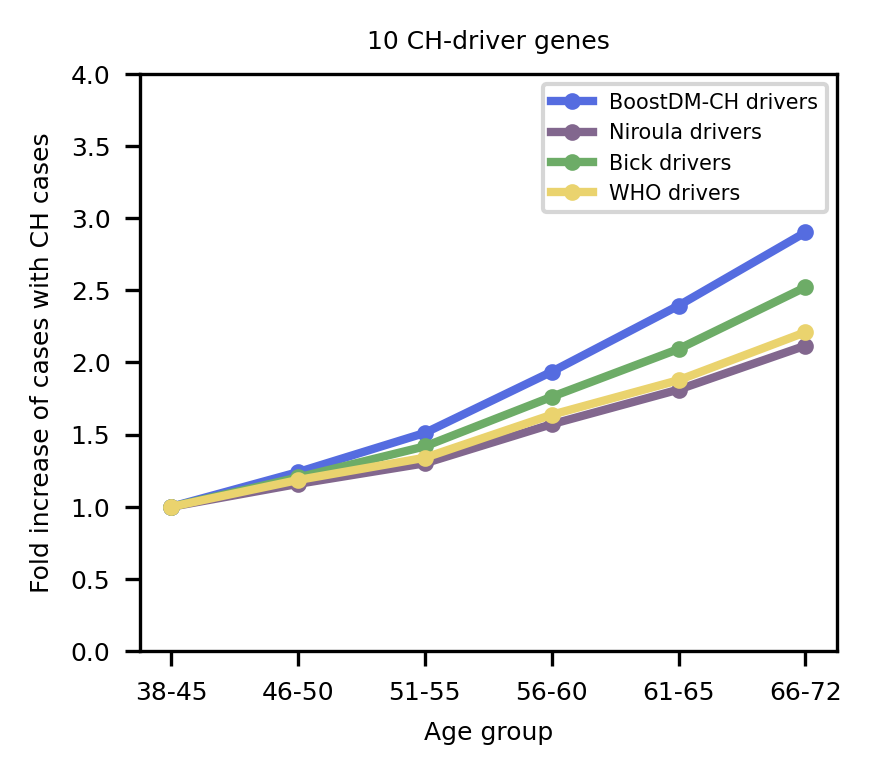

In [17]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 6})
plt.figure(figsize=(3, 2.5))

# positive control
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_nonHN[ukb200K_ch_cancer_nonHN['var_HNALL_pre']==0]
patient_age_BoostDM_driver = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM-CH_nonDriver']==0]
patient_age_Niroula_driver = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_nonDriver']==0]
patient_age_Bick_driver = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_nonDriver']==0]
patient_age_WHO_driver = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_nonDriver']==0]

# agecorr_potCHmut = prop_CH('all', True)
agecorr_drivers_boost = prop_CH_model(patient_age_BoostDM_driver, 'BoostDM-CH_driver', normalize=True)
agecorr_drivers_Niroula = prop_CH_model(patient_age_Niroula_driver, 'Niroula_driver', normalize=True)
agecorr_drivers_Bick = prop_CH_model(patient_age_Bick_driver, 'Bick_driver', normalize=True)
agecorr_drivers_WHO = prop_CH_model(patient_age_WHO_driver, 'WHO_driver', normalize=True)

plt.rcParams["figure.figsize"] = (3.5,2.5)
plt.plot(agecorr_drivers_boost, '.-', linewidth=2, color='#556CE0')
plt.plot(agecorr_drivers_Niroula, '.-', linewidth=2, color='#82678E')
plt.plot(agecorr_drivers_Bick, '.-', linewidth=2, color='#6DAC67')
plt.plot(agecorr_drivers_WHO, '.-', linewidth=2, color='#EAD36E')

plt.title('10 CH-driver genes', fontsize = 6)
plt.xlabel('Age group',size=6)
plt.yticks(fontsize=6)
plt.ylabel('Fold increase of cases with CH cases', fontsize=6)
plt.ylim([0,4])
plt.xticks(np.arange(6), age_groups, size=6)
plt.legend(labels=['BoostDM-CH drivers', 'Niroula drivers', 'Bick drivers', 'WHO drivers'], loc='best', prop={'size': 5})
plt.show()

In [18]:
### Remove cases with prior hematologial cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_nonHN[ukb200K_ch_cancer_nonHN['var_HNALL_pre']==0]
len(ukb200K_ch_cancer_logistic)

467202

In [96]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
    
for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
    if gene.startswith('Niroula'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_driver']==0]
    elif gene.startswith('BoostDM'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_driver']==0]
    elif gene.startswith('Bick'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_driver']==0]
    elif gene.startswith('WHO'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_driver']==0]
    else:
        print('Problem')
        
    if gene.endswith('_driver'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_passengers_matrix).fit()
     
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.255975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320155
         Iterations 7


,gene,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM_driver,1.048911,1.047102,1.050724,0.0,0.017387,sig,0.0
1,Niroula_driver,1.035171,1.033733,1.036611,0.0,0.010241,sig,0.0
2,Bick_driver,1.042434,1.040607,1.044264,0.0,0.013273,sig,0.0
3,WHO_driver,1.036536,1.035052,1.038023,0.0,0.010890,sig,0.0


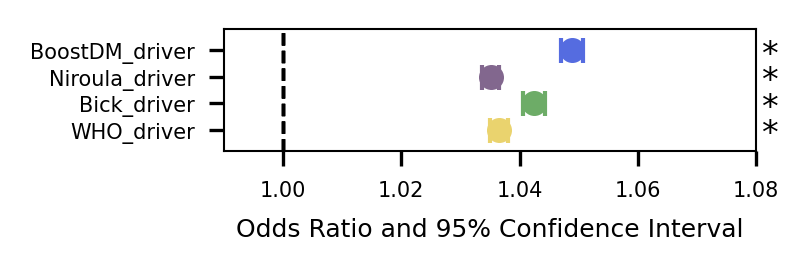

In [82]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4.5, 0.9), dpi=300)
xlimit = 1.08
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'driver' in row['gene']:
        if 'Niroula' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=6)
   
    if row['sig'] == 'sig':
        ax.text(xlimit+0.001, ylimit-idx-0.5, '*', style='italic', size=8)
    else:
        ax.text(xlimit+0.001, ylimit-idx-0.5, 'ns', style='italic', size=8)
        
        
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
# ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.99, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

## 3. Age associations per gene

In [97]:
genes10 = [ 'DNMT3A', 'TET2', 'ASXL1', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2', 'U2AF1', 'GNAS', 'IDH2']

In [98]:
def gene_matrix(mat, gene):
    if gene == 'ASXL1':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'DNMT3A':
        matri = mat[(mat['ASXL1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'GNAS':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'IDH2':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'PPM1D':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SF3B1':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SRSF2':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TET2':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TP53':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'U2AF1':
        matri = mat[(mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    return(matri)

In [102]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc
from tqdm import tqdm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []

for gene in tqdm(genes10):
    CH_gene_matrix = gene_matrix(ukb200K_ch_cancer_logistic, gene)
    for method in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:
        CH_driver_matrix = CH_gene_matrix[CH_gene_matrix[method.replace('_driver', '_nonDriver')]==0]
        num_mut = len(CH_driver_matrix[(CH_driver_matrix[method] == 1)])
        print(gene, method, num_mut)
        try: 
            model_hematopost = smf.logit(formula= method+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
            name.append(gene+'_'+method.replace('_driver', ''))
            OR.append(np.exp(model_hematopost.params[1]))
            cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
            ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
            rsquare.append(model_hematopost.prsquared)
            pval.append(model_hematopost.pvalues[1])
            sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
        
        except Exception as ex:
            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
            message = template.format(type(ex).__name__, ex.args)
            name.append(gene+' '+method.replace('BoostDM', 'BoostDM-CH').replace('_driver', ''))
            OR.append(np.nan)
            cilow.append(np.nan)
            ciup.append(np.nan)
            rsquare.append(np.nan)
            pval.append(1)
            sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
            print(gene+'_'+method, message)

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

  0%|          | 0/10 [00:00<?, ?it/s]

DNMT3A BoostDM_driver 14522
Optimization terminated successfully.
         Current function value: 0.171748
         Iterations 8
DNMT3A Niroula_driver 17963
Optimization terminated successfully.
         Current function value: 0.200297
         Iterations 7
DNMT3A Bick_driver 10464
Optimization terminated successfully.
         Current function value: 0.135017
         Iterations 8
DNMT3A WHO_driver 17809
Optimization terminated successfully.
         Current function value: 0.199155
         Iterations 7


 10%|█         | 1/10 [00:06<00:58,  6.49s/it]

TET2 BoostDM_driver 5835
Optimization terminated successfully.
         Current function value: 0.086978
         Iterations 8
TET2 Niroula_driver 9174
Optimization terminated successfully.
         Current function value: 0.123963
         Iterations 8
TET2 Bick_driver 9174
Optimization terminated successfully.
         Current function value: 0.123963
         Iterations 8
TET2 WHO_driver 9174
Optimization terminated successfully.
         Current function value: 0.123963
         Iterations 8


 20%|██        | 2/10 [00:12<00:50,  6.31s/it]

ASXL1 BoostDM_driver 1452
Optimization terminated successfully.
         Current function value: 0.027750
         Iterations 10
ASXL1 Niroula_driver 1321
Optimization terminated successfully.
         Current function value: 0.025564
         Iterations 10
ASXL1 Bick_driver 1321
Optimization terminated successfully.
         Current function value: 0.025564
         Iterations 10
ASXL1 WHO_driver 1321
Optimization terminated successfully.
         Current function value: 0.025564
         Iterations 10


 30%|███       | 3/10 [00:18<00:44,  6.31s/it]

TP53 BoostDM_driver 1305
Optimization terminated successfully.
         Current function value: 0.025680
         Iterations 10
TP53 Niroula_driver 5071
Optimization terminated successfully.
         Current function value: 0.078479
         Iterations 8
TP53 Bick_driver 1003
Optimization terminated successfully.
         Current function value: 0.020538
         Iterations 10
TP53 WHO_driver 2911
Optimization terminated successfully.
         Current function value: 0.050135
         Iterations 9


 40%|████      | 4/10 [00:25<00:37,  6.26s/it]

PPM1D BoostDM_driver 534
Optimization terminated successfully.
         Current function value: 0.011706
         Iterations 11
PPM1D Niroula_driver 509
Optimization terminated successfully.
         Current function value: 0.011215
         Iterations 11
PPM1D Bick_driver 541
Optimization terminated successfully.
         Current function value: 0.011848
         Iterations 11
PPM1D WHO_driver 542
Optimization terminated successfully.
         Current function value: 0.011868
         Iterations 11


 50%|█████     | 5/10 [00:31<00:31,  6.31s/it]

SF3B1 BoostDM_driver 418
Optimization terminated successfully.
         Current function value: 0.009578
         Iterations 11
SF3B1 Niroula_driver 1331
Optimization terminated successfully.
         Current function value: 0.026150
         Iterations 10
SF3B1 Bick_driver 201
Optimization terminated successfully.
         Current function value: 0.004856
         Iterations 13
SF3B1 WHO_driver 2275
Optimization terminated successfully.
         Current function value: 0.040977
         Iterations 9


 60%|██████    | 6/10 [00:38<00:25,  6.35s/it]

SRSF2 BoostDM_driver 309
Optimization terminated successfully.
         Current function value: 0.007098
         Iterations 12
SRSF2 Niroula_driver 580
Optimization terminated successfully.
         Current function value: 0.012720
         Iterations 11
SRSF2 Bick_driver 227
Optimization terminated successfully.
         Current function value: 0.005237
         Iterations 14
SRSF2 WHO_driver 226
Optimization terminated successfully.
         Current function value: 0.005236
         Iterations 15


 70%|███████   | 7/10 [00:45<00:20,  6.72s/it]

U2AF1 BoostDM_driver 254
Optimization terminated successfully.
         Current function value: 0.006200
         Iterations 14
U2AF1 Niroula_driver 162
Optimization terminated successfully.
         Current function value: 0.004117
         Iterations 15
U2AF1 Bick_driver 102
Optimization terminated successfully.
         Current function value: 0.002646
         Iterations 17
U2AF1 WHO_driver 136
Optimization terminated successfully.
         Current function value: 0.003495
         Iterations 15


 80%|████████  | 8/10 [00:53<00:14,  7.27s/it]

GNAS BoostDM_driver 178
Optimization terminated successfully.
         Current function value: 0.004528
         Iterations 13
GNAS Niroula_driver 195
Optimization terminated successfully.
         Current function value: 0.004899
         Iterations 13
GNAS Bick_driver 179
Optimization terminated successfully.
         Current function value: 0.004538
         Iterations 13
GNAS WHO_driver 158
Optimization terminated successfully.
         Current function value: 0.004071
         Iterations 13


 90%|█████████ | 9/10 [01:01<00:07,  7.48s/it]

IDH2 BoostDM_driver 49
Optimization terminated successfully.
         Current function value: 0.001400
         Iterations 16
IDH2 Niroula_driver 335
Optimization terminated successfully.
         Current function value: 0.007989
         Iterations 12
IDH2 Bick_driver 59
Optimization terminated successfully.
         Current function value: 0.001672
         Iterations 16
IDH2 WHO_driver 59
Optimization terminated successfully.
         Current function value: 0.001672
         Iterations 16


100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


,gene,OR,Lower CI,Upper CI,pval,rsquare,q_value,sig
0,DNMT3A_BoostDM,1.051074,1.048676,1.053478,0.000000e+00,0.017839,0.000000e+00,sig
1,DNMT3A_Niroula,1.046343,1.044211,1.048478,0.000000e+00,0.015402,0.000000e+00,sig
2,DNMT3A_Bick,1.051604,1.048789,1.054426,2.031640e-296,0.016926,2.031640e-295,sig
3,DNMT3A_WHO,1.045726,1.043590,1.047866,0.000000e+00,0.015041,0.000000e+00,sig
4,TET2_BoostDM,1.036593,1.033047,1.040151,6.938366e-94,0.008748,5.550693e-93,sig
5,TET2_Niroula,1.022995,1.020264,1.025734,2.241251e-62,0.004133,1.120625e-61,sig
6,TET2_Bick,1.022995,1.020264,1.025734,2.241251e-62,0.004133,1.120625e-61,sig
7,TET2_WHO,1.022995,1.020264,1.025734,2.241251e-62,0.004133,1.120625e-61,sig
8,ASXL1_BoostDM,1.050857,1.043442,1.058324,6.628188e-43,0.015873,2.209396e-42,sig
9,ASXL1_Niroula,1.054821,1.046938,1.062763,3.387600e-44,0.018269,1.231855e-43,sig


In [112]:
varlist['gene'] = [x.replace('BoostDM', 'BoostDM-CH').replace('_', ' ') for x in varlist['gene']]
varlist

,gene,OR,Lower CI,Upper CI,pval,rsquare,q_value,sig
0,DNMT3A BoostDM-CH,1.051074,1.048676,1.053478,0.000000e+00,0.017839,0.000000e+00,sig
1,DNMT3A Niroula,1.046343,1.044211,1.048478,0.000000e+00,0.015402,0.000000e+00,sig
2,DNMT3A Bick,1.051604,1.048789,1.054426,2.031640e-296,0.016926,2.031640e-295,sig
3,DNMT3A WHO,1.045726,1.043590,1.047866,0.000000e+00,0.015041,0.000000e+00,sig
4,TET2 BoostDM-CH,1.036593,1.033047,1.040151,6.938366e-94,0.008748,5.550693e-93,sig
5,TET2 Niroula,1.022995,1.020264,1.025734,2.241251e-62,0.004133,1.120625e-61,sig
6,TET2 Bick,1.022995,1.020264,1.025734,2.241251e-62,0.004133,1.120625e-61,sig
7,TET2 WHO,1.022995,1.020264,1.025734,2.241251e-62,0.004133,1.120625e-61,sig
8,ASXL1 BoostDM-CH,1.050857,1.043442,1.058324,6.628188e-43,0.015873,2.209396e-42,sig
9,ASXL1 Niroula,1.054821,1.046938,1.062763,3.387600e-44,0.018269,1.231855e-43,sig


In [113]:
color_dict = {
    'BoostDM-CH':'#556CE0',
    'Niroula':'#82678E',
    'Bick':'#6DAC67',
    'WHO':'#EAD36E',
}

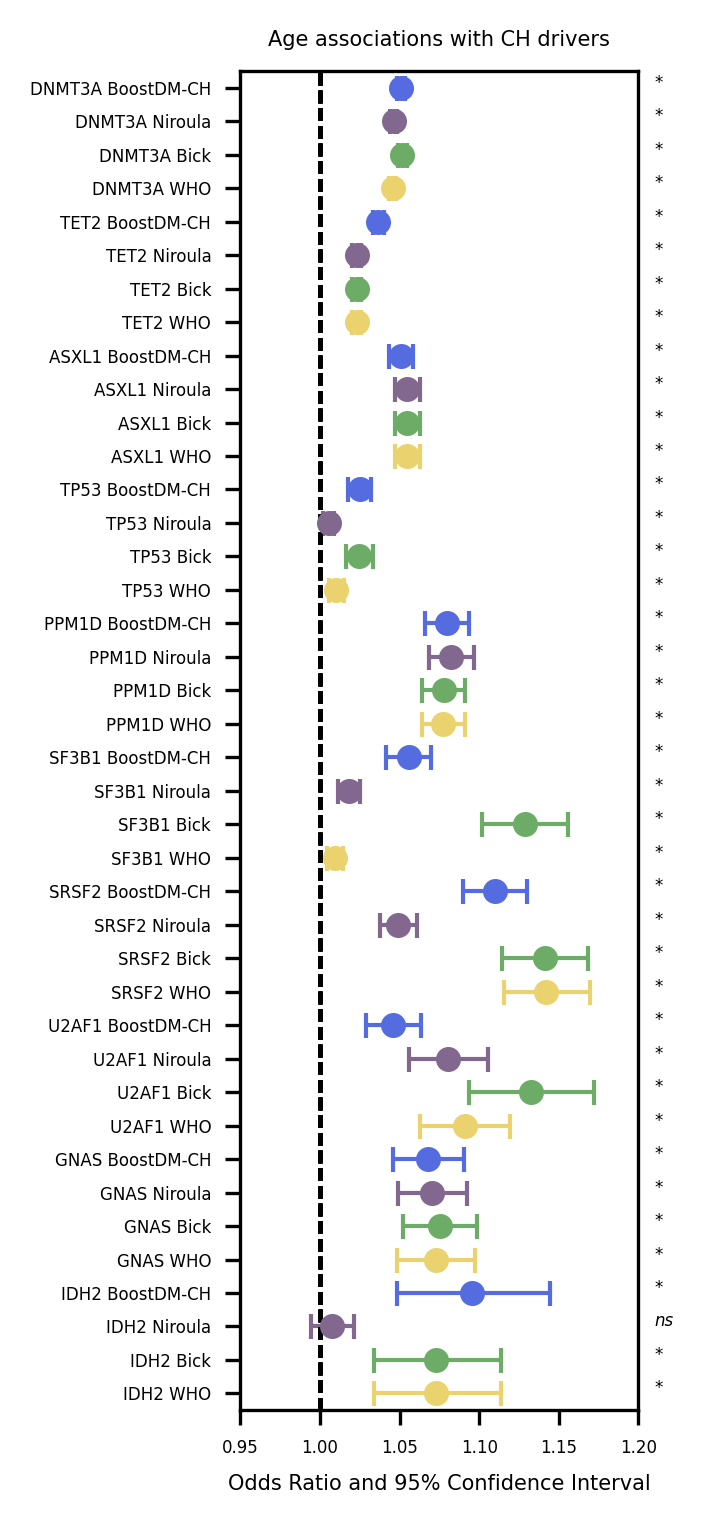

In [116]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2.5, 5))
xlimit = 1.2
ylimit = len(varlist)-1

matplotlib.rcParams.update({'font.size': 4})

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor=color_dict[row.gene.split(' ')[-1]], capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc=color_dict[row.gene.split(' ')[-1]], mec=color_dict[row.gene.split(' ')[-1]])
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx, '*', style='italic', size=4)
    else:
        ax.text(xlimit+0.01, ylimit-idx, 'ns', style='italic', size=4)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=5)
ax.set_title('Age associations with CH drivers', fontdict={'size':5})
plt.tight_layout()
plt.xlim([0.95, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.savefig('Age_gene_methods.png', bbox_inches = 'tight', dpi=400)
plt.show()

## 4. Smoking association

In [19]:
# Upload smoking features (NOT PROVIDED)
# File generated in section 0_Clinical_phenotypes
covariables = pd.read_csv('../../../Paper_data/UKB_clinic_info/dataframe_cases_covariables_v2.txt.gz',sep="\t")
covariables = covariables[covariables['patient'].isin(ukb200K_ch_cancer_nonHN['patient'].tolist())]
covariables = covariables.reset_index(drop=True)
covariables.columns

/tmp/jobs/jramis/9874679/ipykernel_17330/949830155.py:3: DtypeWarning: Columns (60,294,298,299,302,306,308,310,312,314,316,320,324,326,328,330,336,338,340,346,348,350,352,354,356,362,364,366,368,370,372,374,376,380,382,394,396,398,400,404,406,408,412,414,416,418,420,424,426,428,430,434,436,442,444,446,448,450,454,456,458,464,465,466,467,468,469,472,473,474,475,478,479,480,481,482,483,486,487,488,489,490,491,492,493,496,497,498,499,500,1269,1285,1286,1287,1288,1289,1292,1293,1294,1295,1296,1297,1319) have mixed types. Specify dtype option on import or set low_memory=False.
  covariables = pd.read_csv('../../../Paper_data/UKB_clinic_info/dataframe_cases_covariables_v2.txt.gz',sep="\t")


Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       'systolic', 'blood_press', 'antihyper', 'HYP_cov', 'lipid_low_drug',
       'HDL_cholesterol', 'Cholesterol', 'LDL_direct', 'DYSL_cov', 'BMI_cov'],
      dtype='object', length=1383)

In [20]:
ukb200K_ch_cancer_nonHN = ukb200K_ch_cancer_nonHN.reset_index(drop=True)

In [21]:
# Check patients is exact, but the important thing is the index
def are_lists_identical(list1, list2):
    if len(list1) != len(list2):
        return False
    
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return False
    
    return True

are_lists_identical(covariables['patient'], ukb200K_ch_cancer_nonHN['patient'])

True

In [23]:
# Include new features
import math
ukb200K_ch_cancer_nonHN['40007-0.0'] = covariables['40007-0.0']
ukb200K_ch_cancer_nonHN['Death_status'] = covariables['40007-0.0'].apply(lambda x: 0 if math.isnan(x) else 1)
ukb200K_ch_cancer_nonHN['Death_status'] = covariables['40007-0.0'].apply(lambda x: 0 if math.isnan(x) else 1)
ukb200K_ch_cancer_nonHN['Smoking'] = np.where(covariables['20116-0.0_x']==-3, np.nan, covariables['20116-0.0_x'])
ukb200K_ch_cancer_nonHN['Packages_cigarettes'] = np.where(covariables['20116-0.0_x']==0, 0, covariables['20161-0.0_x']) 

# Removing previous smokers
ukb200K_ch_cancer_nonHN['Smoking_1'] = np.where(ukb200K_ch_cancer_nonHN['Smoking']==1, np.nan, ukb200K_ch_cancer_nonHN['Smoking'])
ukb200K_ch_cancer_nonHN['Smoking_1'] = np.where(ukb200K_ch_cancer_nonHN['Smoking_1']==2, 1, ukb200K_ch_cancer_nonHN['Smoking_1'])
# Togather previous with current
ukb200K_ch_cancer_nonHN['Smoking_2'] = np.where(ukb200K_ch_cancer_nonHN['Smoking']==2, 1, ukb200K_ch_cancer_nonHN['Smoking'])

In [24]:
# Remove cases with previous hematologic cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_nonHN[ukb200K_ch_cancer_nonHN['var_HNALL_pre']==0]

In [25]:
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

In [124]:
#perform logistic regression separetly
import statsmodels.formula.api as smf

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
    
    
for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
    #we have exclude pre hematological cases
    if gene.startswith('Niroula'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_driver']==0]
    elif gene.startswith('BoostDM'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_driver']==0]
    elif gene.startswith('Bick'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_driver']==0]
    elif gene.startswith('WHO'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_driver']==0]
    else:
        print('Problem')
        
    if gene.endswith('_driver'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + Smoking_2 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + Smoking_2 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_passengers_matrix).fit()
     
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.255868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320017
         Iterations 7


,gene,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM_driver,1.124145,1.095399,1.153645,8.424025e-19,0.017784,sig,1.123203e-18
1,Niroula_driver,1.106159,1.082593,1.130238,4.203260e-20,0.010581,sig,8.406519e-20
2,Bick_driver,1.116694,1.087275,1.146909,5.377373e-16,0.013605,sig,5.377373e-16
3,WHO_driver,1.113075,1.088714,1.137981,2.356844e-21,0.011259,sig,9.427378e-21


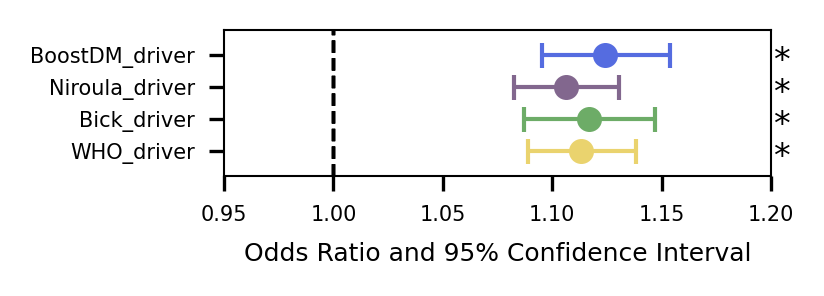

In [125]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.1, 0.9), dpi=300)
xlimit = 1.2
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'driver' in row['gene']:
        if 'Niroula' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=6)
   
    if row['sig'] == 'sig':
        ax.text(xlimit+0.001, ylimit-idx-0.5, '*', style='italic', size=8)
    else:
        ax.text(xlimit+0.001, ylimit-idx-0.5, 'ns', style='italic', size=8)
        
        
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
# ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.95, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

## 5. All cause death

In [126]:
#perform logistic regression separetly
import statsmodels.formula.api as smf

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
    
for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
    if gene.startswith('Niroula'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_driver']==0]
    elif gene.startswith('BoostDM'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_driver']==0]
    elif gene.startswith('Bick'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_driver']==0]
    elif gene.startswith('WHO'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_driver']==0]
    else:
        print('Problem')
        
    if gene.endswith('_driver'):
        model_hematopost = smf.logit(formula= 'Death_status ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= 'Death_status ~ 1 + '+gene+' + age_recruitment_X + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_passengers_matrix).fit()
     
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.239889
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.240375
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.238956
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.240261
         Iterations 8


,gene,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM_driver,1.261381,1.208509,1.316567,2.195264e-26,0.082568,sig,8.781054e-26
1,Niroula_driver,1.197758,1.154038,1.243134,1.879153e-21,0.082093,sig,2.505537e-21
2,Bick_driver,1.237037,1.182900,1.293652,1.200258e-20,0.082408,sig,1.200258e-20
3,WHO_driver,1.205446,1.160474,1.252161,5.860993e-22,0.082128,sig,1.172199e-21


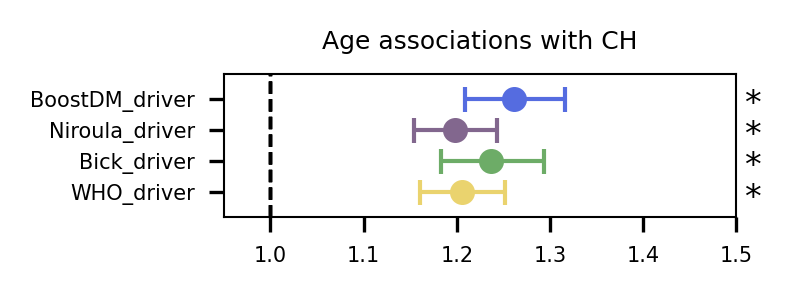

In [127]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4, 0.9), dpi=300)
xlimit = 1.5
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'driver' in row['gene']:
        if 'Niroula' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=6)
   
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx-0.5, '*', style='italic', size=8)
    else:
        ax.text(xlimit+0.01, ylimit-idx-0.5, 'ns', style='italic', size=8)
        
        
# plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.95, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

## 6. Post hematological cancer

In [128]:
#perform logistic regression separetly
import statsmodels.formula.api as smf

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
    
for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
    if gene.startswith('Niroula'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_driver']==0]
    elif gene.startswith('BoostDM'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_driver']==0]
    elif gene.startswith('Bick'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_driver']==0]
    elif gene.startswith('WHO'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_driver']==0]
    else:
        print('Problem')
        
    if gene.endswith('_driver'):
        model_hematopost = smf.logit(formula= 'var_HNALL_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_matrix).fit()
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= 'var_HNALL_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_passengers_matrix).fit()
     
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.059248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059480
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058856
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059443
         Iterations 9


,gene,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM_driver,2.164748,1.987680,2.357589,2.133380e-70,0.038430,sig,8.533518e-70
1,Niroula_driver,1.852328,1.713319,2.002615,4.203061e-54,0.036573,sig,4.203061e-54
2,Bick_driver,2.167658,1.984638,2.367557,3.172864e-66,0.038198,sig,6.345727e-66
3,WHO_driver,1.897434,1.753166,2.053574,9.482235e-57,0.037068,sig,1.264298e-56


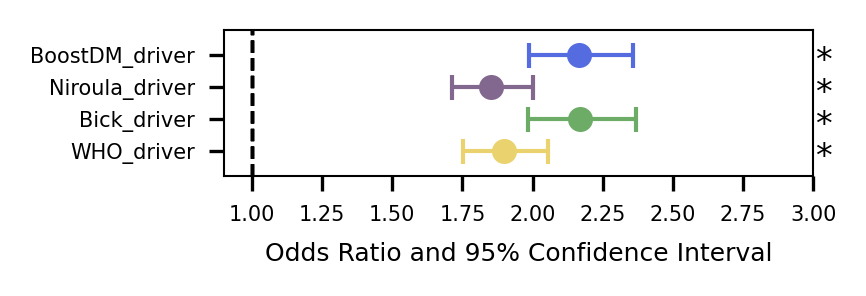

In [129]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.8, 0.9), dpi=300)
xlimit = 3
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'driver' in row['gene']:
        if 'Niroula' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=6)
   
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx-0.5, '*', style='italic', size=8)
    else:
        ax.text(xlimit+0.01, ylimit-idx-0.5, 'ns', style='italic', size=8)
        
        
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
# ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.9, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

## 7. Post-Myeloid

In [131]:
#perform logistic regression separetly
import statsmodels.formula.api as smf

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
    
for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
    if gene.startswith('Niroula'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Niroula_driver']==0]
    elif gene.startswith('BoostDM'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['BoostDM_driver']==0]
    elif gene.startswith('Bick'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['Bick_driver']==0]
    elif gene.startswith('WHO'):
        CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['WHO_driver']==0]
    else:
        print('Problem')
        
    if gene.endswith('_driver'):
        model_hematopost = smf.logit(formula= 'var_MM_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_matrix).fit()
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= 'var_MM_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_passengers_matrix).fit()
     
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.017193
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017436
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017003
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017434
         Iterations 11


,gene,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM_driver,5.799961,5.062649,6.644654,1.144736e-141,0.069855,sig,2.289473e-141
1,Niroula_driver,4.524479,3.971788,5.154079,3.711186e-114,0.062499,sig,3.711186e-114
2,Bick_driver,5.983211,5.211598,6.869066,2.872703e-142,0.069528,sig,1.149081e-141
3,WHO_driver,4.731289,4.150732,5.393048,9.204682e-120,0.063456,sig,1.227291e-119


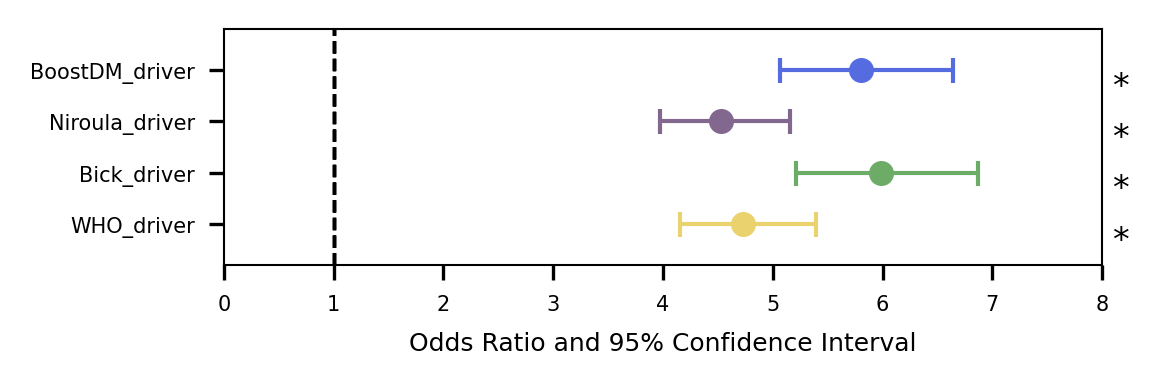

In [132]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4.1, 1.2), dpi=300)
xlimit = 8
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'driver' in row['gene']:
        if 'Niroula' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=6)
   
    if row['sig'] == 'sig':
        ax.text(xlimit+0.1, ylimit-idx-0.5, '*', style='italic', size=8)
    else:
        ax.text(xlimit+0.1, ylimit-idx-0.5, 'ns', style='italic', size=8)
        
        
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
# ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.0, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

## 8. Post-cancer

In [26]:
# Generate the post_cancer variable
ukb200K_ch_cancer_nonHN['cancer1_post'] = ukb200K_ch_cancer_nonHN['years_tocancer1'].apply(lambda x: 1 if x > 0 else 0)

In [28]:
# Select cases without prior cancer
ukb200K_ch_cancer_nonpreHEMATO = ukb200K_ch_cancer_nonHN[ukb200K_ch_cancer_nonHN['var_HNALL_var']==0]
ukb200K_ch_cancer_nonpreHEMATO = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['cancer1_pre']==0]
print(len(ukb200K_ch_cancer_nonpreHEMATO))

426942


In [135]:
#perform logistic regression separetly
import statsmodels.formula.api as smf

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
    
for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
    #we have exclude pre hematological cases
    if gene.startswith('Niroula'):
        CH_driver_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['Niroula_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['Niroula_driver']==0]
    elif gene.startswith('BoostDM'):
        CH_driver_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['BoostDM_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['BoostDM_driver']==0]
    elif gene.startswith('Bick'):
        CH_driver_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['Bick_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['Bick_driver']==0]
    elif gene.startswith('WHO'):
        CH_driver_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['WHO_nonDriver']==0]
        CH_passengers_matrix = ukb200K_ch_cancer_nonpreHEMATO[ukb200K_ch_cancer_nonpreHEMATO['WHO_driver']==0]
    else:
        print('Problem')
        
    if gene.endswith('_driver'):
        model_hematopost = smf.logit(formula= 'cancer1_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_matrix).fit()
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= 'cancer1_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_passengers_matrix).fit()
     
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.404376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403704
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404452
         Iterations 7


,gene,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM_driver,1.056334,1.018862,1.095185,0.002940,0.045681,sig,0.006221
1,Niroula_driver,1.046976,1.015594,1.079326,0.003111,0.045591,sig,0.006221
2,Bick_driver,1.045440,1.006955,1.085396,0.020226,0.045681,sig,0.024850
3,WHO_driver,1.036507,1.004545,1.069486,0.024850,0.045641,sig,0.024850


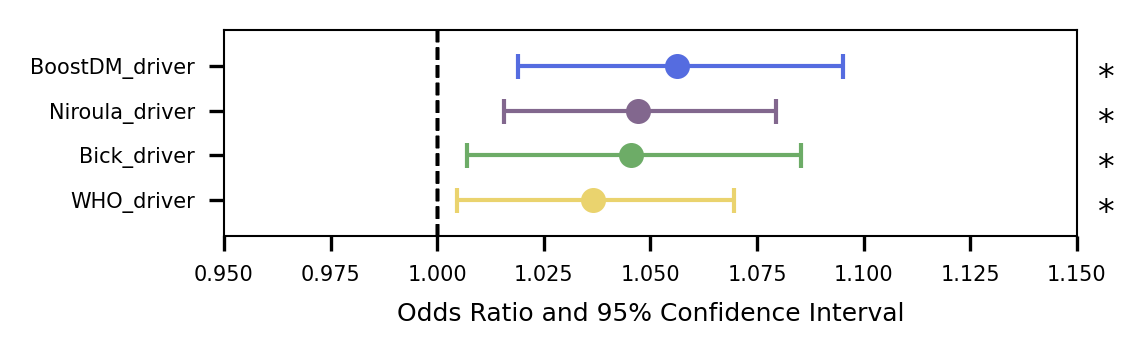

In [136]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 1.1), dpi=300)
xlimit = 1.15
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'driver' in row['gene']:
        if 'Niroula' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=6)
   
    if row['sig'] == 'sig':
        ax.text(xlimit+0.005, ylimit-idx-0.5, '*', style='italic', size=8)
    else:
        ax.text(xlimit+0.005, ylimit-idx-0.5, 'ns', style='italic', size=8)
        
        
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
# ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.95, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

## 9. Heart Failure

In [31]:
# Upload cardio vascular disease features (NOT PROVIDED)
# File generated in section 0_Clinical_phenotypes
patient_cvd = pd.read_csv('../../../Paper_data/UKB_clinic_info/cvd_ukb450k_Siddharta_670124_je.txt.gz', sep="\t")
patient_cvd = patient_cvd.rename({'eid': 'patient'}, axis=1)
patient_cvd.columns

Index(['patient', 'var_MI_years', 'var_MI_var', 'var_MI_post', 'var_MI_pre',
       'var_STR_years', 'var_STR_var', 'var_STR_post', 'var_STR_pre',
       'var_ISTR_years', 'var_ISTR_var', 'var_ISTR_post', 'var_ISTR_pre',
       'var_CAD_years', 'var_CAD_var', 'var_CAD_post', 'var_CAD_pre',
       'var_HF_years', 'var_HF_var', 'var_HF_post', 'var_HF_pre',
       'var_AF_years', 'var_AF_var', 'var_AF_post', 'var_AF_pre'],
      dtype='object')

In [33]:
### Merge

ukb200K_ch_cancer_nonHN = pd.merge(ukb200K_ch_cancer_nonHN, patient_cvd,  how='inner',
                              on='patient')

In [34]:
# Include atherosclerosis
ukb200K_ch_cancer_nonHN['var_ATH_var'] = covariables['I70_var']
ukb200K_ch_cancer_nonHN['var_ATH_years'] = covariables['I70_years']
ukb200K_ch_cancer_nonHN['var_ATH_post'] = covariables['I70_post']
ukb200K_ch_cancer_nonHN['var_ATH_pre'] = covariables['I70_pre']

/tmp/jobs/jramis/9874679/ipykernel_17330/1285317596.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ukb200K_ch_cancer_nonHN['var_ATH_var'] = covariables['I70_var']
/tmp/jobs/jramis/9874679/ipykernel_17330/1285317596.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ukb200K_ch_cancer_nonHN['var_ATH_years'] = covariables['I70_years']
/tmp/jobs/jramis/9874679/ipykernel_17330/1285317596.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

In [35]:
#Include the new variables
ukb200K_ch_cancer_nonHN['DYSL_cov'] = covariables['DYSL_cov']
ukb200K_ch_cancer_nonHN['HYP_cov'] = covariables['HYP_cov']
ukb200K_ch_cancer_nonHN['DMT2_cov'] = covariables['DMT2_cov']
ukb200K_ch_cancer_nonHN['BMI_cov'] = covariables['BMI_cov']

/tmp/jobs/jramis/9874679/ipykernel_17330/264678574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ukb200K_ch_cancer_nonHN['DYSL_cov'] = covariables['DYSL_cov']
/tmp/jobs/jramis/9874679/ipykernel_17330/264678574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ukb200K_ch_cancer_nonHN['HYP_cov'] = covariables['HYP_cov']
/tmp/jobs/jramis/9874679/ipykernel_17330/264678574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [37]:
# Composite CVD definition
yeears = ['var_MI_years', 'var_STR_years', 'var_ISTR_years', 'var_CAD_years', 'var_HF_years', 'var_AF_years', 'var_ATH_years']
ukb200K_ch_cancer_nonHN['var_CVD_years'] = ukb200K_ch_cancer_nonHN.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer_nonHN['var_CVD_var'] = np.where(ukb200K_ch_cancer_nonHN['var_CVD_years'].notnull(), 1, 0)
ukb200K_ch_cancer_nonHN['var_CVD_post'] = np.where(ukb200K_ch_cancer_nonHN['var_CVD_years'] > 0, 1, 0)
ukb200K_ch_cancer_nonHN['var_CVD_pre'] = np.where(ukb200K_ch_cancer_nonHN['var_CVD_years'] < 0, 1, 0)

In [142]:
ukb200K_ch_cancerlogistic = ukb200K_ch_cancer_nonHN[ukb200K_ch_cancer_nonHN['var_HNALL_pre']==0]
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_logistic.reset_index(drop=True)

In [144]:
#perform logistic regression separetly
import statsmodels.formula.api as smf

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
mat_gen = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['var_HF_pre']==0]

for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
    #we have exclude pre hematological cases
    if gene.startswith('Niroula'):
        CH_driver_matrix = mat_gen[mat_gen['Niroula_nonDriver']==0]
        CH_passengers_matrix = mat_gen[mat_gen['Niroula_driver']==0]
    elif gene.startswith('BoostDM'):
        CH_driver_matrix = mat_gen[mat_gen['BoostDM_nonDriver']==0]
        CH_passengers_matrix = mat_gen[mat_gen['BoostDM_driver']==0]
    elif gene.startswith('Bick'):
        CH_driver_matrix = mat_gen[mat_gen['Bick_nonDriver']==0]
        CH_passengers_matrix = mat_gen[mat_gen['Bick_driver']==0]
    elif gene.startswith('WHO'):
        CH_driver_matrix = mat_gen[mat_gen['WHO_nonDriver']==0]
        CH_passengers_matrix = mat_gen[mat_gen['WHO_driver']==0]
    else:
        print('Problem')
        
    if gene.endswith('_driver'):
        model_hematopost = smf.logit(formula= 'var_HF_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + DYSL_cov + HYP_cov + DMT2_cov + BMI_cov + Smoking_2', data=CH_driver_matrix).fit()
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= 'var_HF_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + DYSL_cov + HYP_cov + DMT2_cov + BMI_cov + Smoking_2', data=CH_passengers_matrix).fit()
     
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.113898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113988
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113473
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.114023
         Iterations 9


,gene,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM_driver,1.133459,1.059105,1.213033,0.000296,0.150975,sig,0.000865
1,Niroula_driver,1.100068,1.037154,1.166798,0.001503,0.151250,sig,0.001503
2,Bick_driver,1.130350,1.053282,1.213057,0.000672,0.151421,sig,0.000896
3,WHO_driver,1.113849,1.048935,1.182779,0.000432,0.151310,sig,0.000865


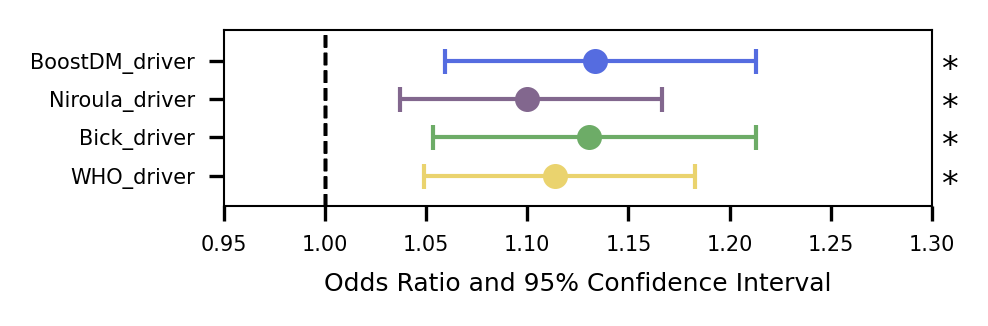

In [145]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4.2, 1), dpi=300)
xlimit = 1.3
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'driver' in row['gene']:
        if 'Niroula' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=6)
   
    if row['sig'] == 'sig':
        ax.text(xlimit+0.005, ylimit-idx-0.5, '*', style='italic', size=8)
    else:
        ax.text(xlimit+0.005, ylimit-idx-0.5, 'ns', style='italic', size=8)
        
        
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
# ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.95, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

# 10. Infectioius disease association

In [38]:
# Upload smoking features (NOT PROVIDED)
# File generated in section 0_Clinical_phenotypes
patient_infection = pd.read_csv('../../../Paper_data/UKB_clinic_info/Infection_ukb450k_670124_bacterial_infection.txt.gz',sep="\t")
patient_infection = patient_infection.rename({'eid': 'patient'}, axis=1)
patient_infection = patient_infection[patient_infection['patient'].isin(ukb200K_ch_cancer_nonHN['patient'].tolist())]
patient_infection = patient_infection.reset_index(drop=True)
patient_infection.columns

Index(['patient', 'var_Sepsis_years', 'var_Sepsis_var', 'var_Sepsis_post',
       'var_Sepsis_pre', 'var_Pneumonia_years', 'var_Pneumonia_var',
       'var_Pneumonia_post', 'var_Pneumonia_pre', 'var_Gastroenteritis_years',
       ...
       'var_B95_post', 'var_B95_pre', 'var_B96_years', 'var_B96_var',
       'var_B96_post', 'var_B96_pre', 'var_B98_years', 'var_B98_var',
       'var_B98_post', 'var_B98_pre'],
      dtype='object', length=121)

In [39]:
ukb200K_ch_cancer_nonHN = pd.merge(ukb200K_ch_cancer_nonHN, patient_infection,  how='inner',
                              on='patient')

In [40]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_nonHN[ukb200K_ch_cancer_nonHN['var_HNALL_pre']==0]

In [150]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc


name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
mat_gen = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['var_Composite_any_infection_pre']==0]

for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
    #we have exclude pre hematological cases
    if gene.startswith('Niroula'):
        CH_driver_matrix = mat_gen[mat_gen['Niroula_nonDriver']==0]
        CH_passengers_matrix = mat_gen[mat_gen['Niroula_driver']==0]
    elif gene.startswith('BoostDM'):
        CH_driver_matrix = mat_gen[mat_gen['BoostDM_nonDriver']==0]
        CH_passengers_matrix = mat_gen[mat_gen['BoostDM_driver']==0]
    elif gene.startswith('Bick'):
        CH_driver_matrix = mat_gen[mat_gen['Bick_nonDriver']==0]
        CH_passengers_matrix = mat_gen[mat_gen['Bick_driver']==0]
    elif gene.startswith('WHO'):
        CH_driver_matrix = mat_gen[mat_gen['WHO_nonDriver']==0]
        CH_passengers_matrix = mat_gen[mat_gen['WHO_driver']==0]
    else:
        print('Problem')
        
    if gene.endswith('_driver'):
        model_hematopost = smf.logit(formula= 'var_Composite_any_infection_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2 + var_HNALL_post', data=CH_driver_matrix).fit()
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= 'var_Composite_any_infection_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2 + var_HNALL_post', data=CH_passengers_matrix).fit()
     
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.327001
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326323
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327317
         Iterations 7


,gene,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM_driver,1.080369,1.038384,1.124052,0.000132,0.039575,sig,0.000443
1,Niroula_driver,1.059563,1.024473,1.095854,0.000760,0.039273,sig,0.001013
2,Bick_driver,1.065834,1.022781,1.110698,0.002440,0.039584,sig,0.002440
3,WHO_driver,1.067096,1.030943,1.104516,0.000222,0.039434,sig,0.000443


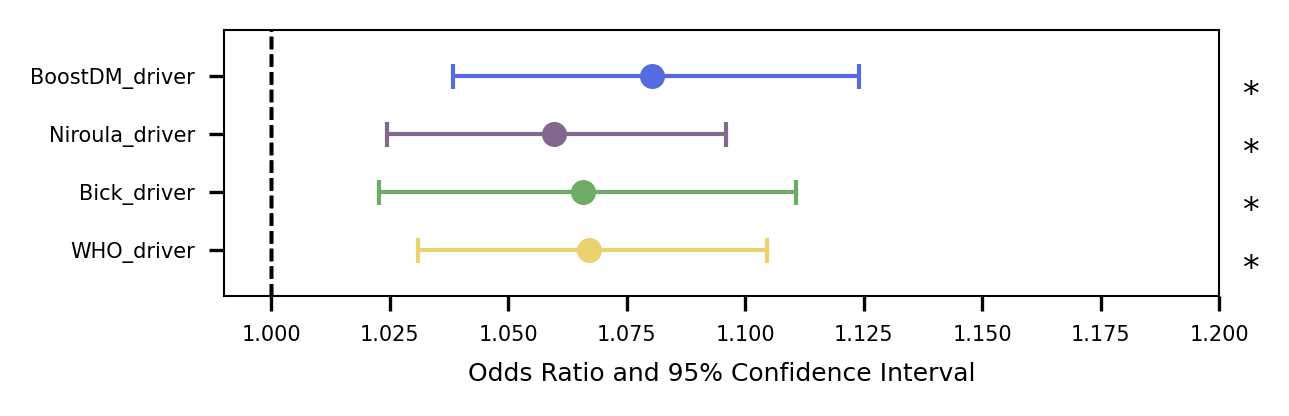

In [151]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(7,1.3), dpi=300)
xlimit = 1.2
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'driver' in row['gene']:
        if 'Niroula' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    else:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                     ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        plt.tick_params(axis='both', which='major', labelsize=6)
   
    if row['sig'] == 'sig':
        ax.text(xlimit+0.005, ylimit-idx-0.5, '*', style='italic', size=8)
    else:
        ax.text(xlimit+0.005, ylimit-idx-0.5, 'ns', style='italic', size=8)
        
        
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)
# ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.99, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()

# 11. CH associations comparisons all togather

In [153]:
Dic_variables = {'age_recruitment_x':[0.99, 1.08, 0.001],
                 'Smoking_2':[0.95, 1.2, 0.005],
                 'Death_status':[0.95, 1.5, 0.01],
                 'var_MM_post':[0, 8, 0.1],
                 'var_HF_post':[0.95, 1.3, 0.005],
                 'var_Composite_any_infection_post':[0.95, 1.2, 0.005]
                }

variables = ['age_recruitment_x', 'Smoking_2', 'Death_status', 'var_MM_post', 'var_HF_post', 'var_Composite_any_infection_post']
variables

['age_recruitment_x',
 'Smoking_2',
 'Death_status',
 'var_MM_post',
 'var_HF_post',
 'var_Composite_any_infection_post']

age_recruitment_x
Optimization terminated successfully.
         Current function value: 0.255975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320155
         Iterations 7
Smoking_2
Optimization terminated successfully.
         Current function value: 0.255868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320017
         Iterations 7
Death_status
Optimization terminated successfully.
         Current function value: 0.239889
         Iterations 8
Optimization terminated successfully.
   

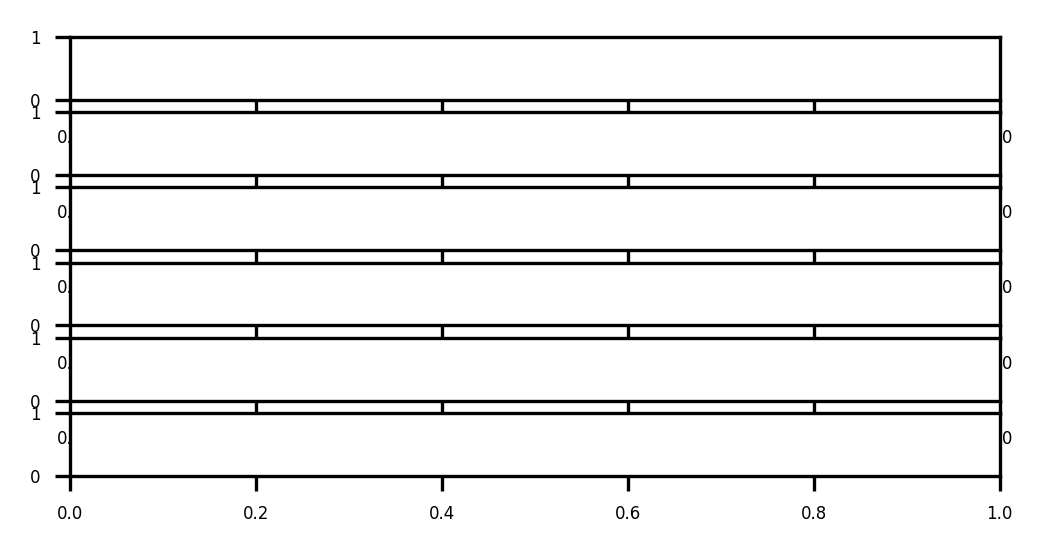

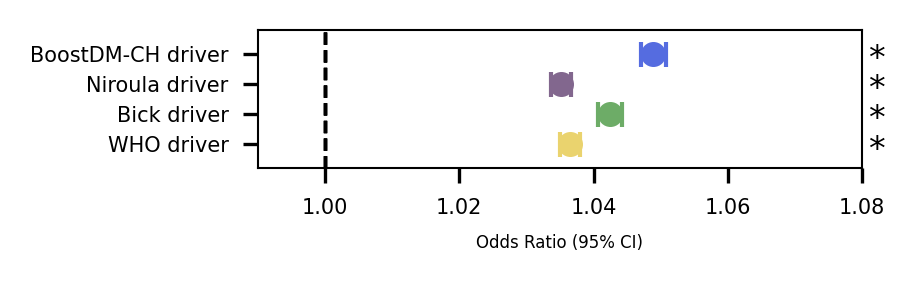

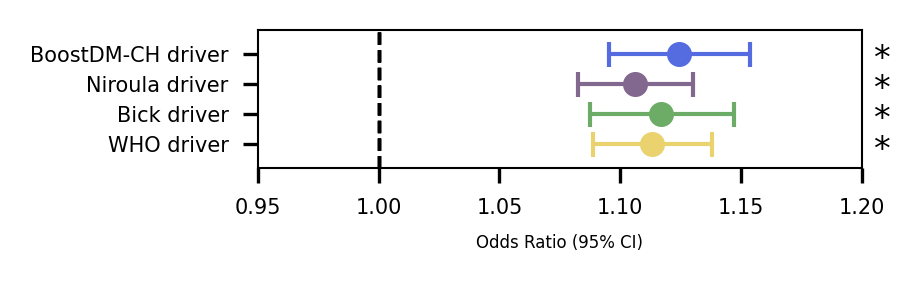

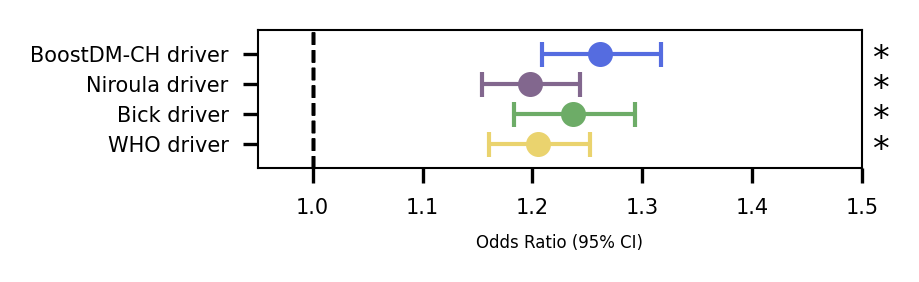

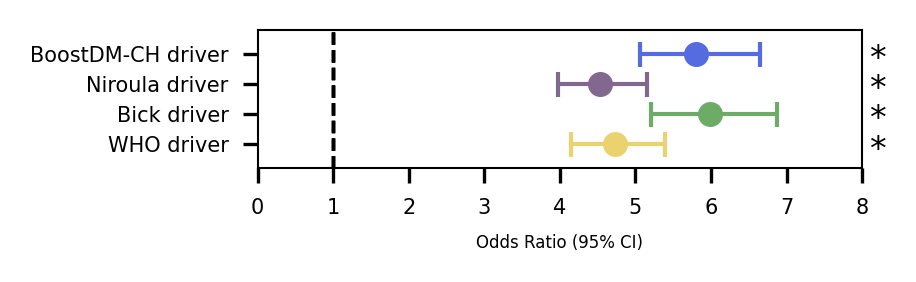

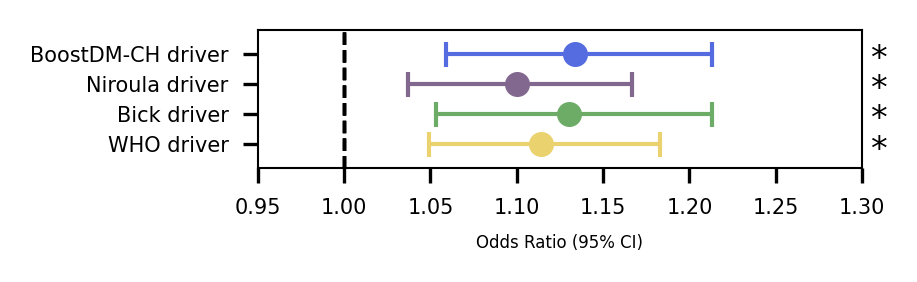

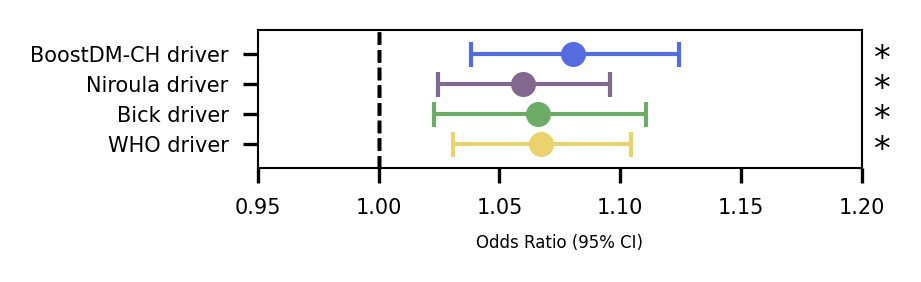

In [157]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc


fig, axes = plt.subplots(len(variables), 1, figsize=(4, 1.9))
axes = axes.flatten()

for i, variable in enumerate(variables):
    print(variable)
    
    if variable == 'var_HF_post':
        mat_gen = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['var_HF_pre']==0]
    elif variable == 'var_Composite_any_infection_post':
        mat_gen = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['var_Composite_any_infection_pre']==0]
    else:
        mat_gen = ukb200K_ch_cancer_logistic.copy()

    ax = axes[i]
    
    name = []
    OR = []
    cilow = []
    ciup = []
    rsquare = []
    pval = []
    sig = []

    for gene in ['BoostDM_driver', 'Niroula_driver', 'Bick_driver', 'WHO_driver']:   
        #we have exclude pre hematological cases
        if gene.startswith('Niroula'):
            CH_driver_matrix = mat_gen[mat_gen['Niroula_nonDriver']==0]
            CH_passengers_matrix = mat_gen[mat_gen['Niroula_driver']==0]
        elif gene.startswith('BoostDM'):
            CH_driver_matrix = mat_gen[mat_gen['BoostDM_nonDriver']==0]
            CH_passengers_matrix = mat_gen[mat_gen['BoostDM_driver']==0]
        elif gene.startswith('Bick'):
            CH_driver_matrix = mat_gen[mat_gen['Bick_nonDriver']==0]
            CH_passengers_matrix = mat_gen[mat_gen['Bick_driver']==0]
        elif gene.startswith('WHO'):
            CH_driver_matrix = mat_gen[mat_gen['WHO_nonDriver']==0]
            CH_passengers_matrix = mat_gen[mat_gen['WHO_driver']==0]
        else:
            print('Problem')

        if variable == 'age_recruitment_x':
            model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        elif variable == 'Smoking_2':
            model_hematopost = smf.logit(formula= gene+' ~ 1 + Smoking_2 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        elif variable == 'Death_status':
            model_hematopost = smf.logit(formula= 'Death_status ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        elif variable == 'var_MM_post':
            model_hematopost = smf.logit(formula= 'var_MM_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2', data=CH_driver_matrix).fit()
        elif variable == 'var_HF_post':
            model_hematopost = smf.logit(formula= 'var_HF_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + DYSL_cov + HYP_cov + DMT2_cov + BMI_cov + Smoking_2', data=CH_driver_matrix).fit()
        elif variable == 'var_Composite_any_infection_post':
            model_hematopost = smf.logit(formula= 'var_Composite_any_infection_post ~ 1 + '+gene+' + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + Smoking_2 + var_HNALL_post', data=CH_driver_matrix).fit()


        name.append(gene)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

    varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
    varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
    varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]

    fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2.6, 0.6), dpi=300)
    xlimit = Dic_variables[variable][1]
    ylimit = len(varlist)-1

    for idx, row in varlist.iloc[::-1].iterrows():
        ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
        if 'Niroula' in row['gene']:
            ax.errorbar(x=[row['OR']], y=['Niroula driver'], xerr=ci,
                     ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#82678E", mec="#82678E")
            ax.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'Bick' in row['gene']:
            ax.errorbar(x=[row['OR']], y=['Bick driver'], xerr=ci,
                     ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#6DAC67", mec="#6DAC67")
            ax.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        elif 'WHO' in row['gene']:
            ax.errorbar(x=[row['OR']], y=['WHO driver'], xerr=ci,
                     ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#EAD36E", mec="#EAD36E")
            ax.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        else:
            ax.errorbar(x=[row['OR']], y=['BoostDM-CH driver'], xerr=ci,
                     ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="#556CE0", mec="#556CE0")
            ax.axvline(x=1, linewidth=0.8, linestyle='--', color='black')

        if row['sig'] == 'sig':
            ax.text(xlimit+Dic_variables[variable][2], ylimit-idx-0.5, '*', style='italic', size=8)
        else:
            ax.text(xlimit+Dic_variables[variable][2], ylimit-idx-0.5, 'ns', style='italic', size=8)


    ax.set_xlabel('Odds Ratio (95% CI)', fontsize=4)
    # ax.set_title('Age associations with CH', fontdict={'size':6})
    ax.set_xlim([Dic_variables[variable][0], xlimit])
    ax.set_ylim(-.8, ylimit+.8)
    ax.tick_params(axis='y',labelsize=5)
    ax.tick_params(axis='x',labelsize=5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)  # change width
